# Bayesian Naive Bayes - T1

## Preámbulo

#### Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#### Datos

In [2]:
df = pd.read_csv('FATS_OGLE_bin.dat', sep='\t')
features = ['Amplitude', 'Std', 'Period', 'Mean', 'MaxSlope', 'Meanvariance', 'LinearTrend']
y_all = np.array(df['Class'])
X_all = np.array(df[features])

In [3]:
def train_test_split(features, labels, proportion):
    training_indexes = np.random.rand(len(features)) < proportion
    return (features[training_indexes], features[~training_indexes],
        labels[training_indexes], labels[~training_indexes])

X_train, X_test, y_train, y_test = train_test_split(features=X_all, labels=y_all, proportion=0.9)

#### Visualización de previa de los datos
Para visualizar como distribuyen cada una de las características, realizo dos tipos de gráficos:
1) Un histograma que muestra la cantidad de muestras por valor para cada característica
2) Un histograma que muestra la cantidad de muestras por valor y por clase para cada característica

El primero sirve para ver como distribuyen las características, y el segundo para ver como varían las distribuciones de dichas características por clase, para tener una noción de qué distribuciones utilizar posteriormente en el desarrollo del problema, y también cuales pueden ser eliminadas porque no otorgan valor alguno de acuerdo a algún análisis posterior.

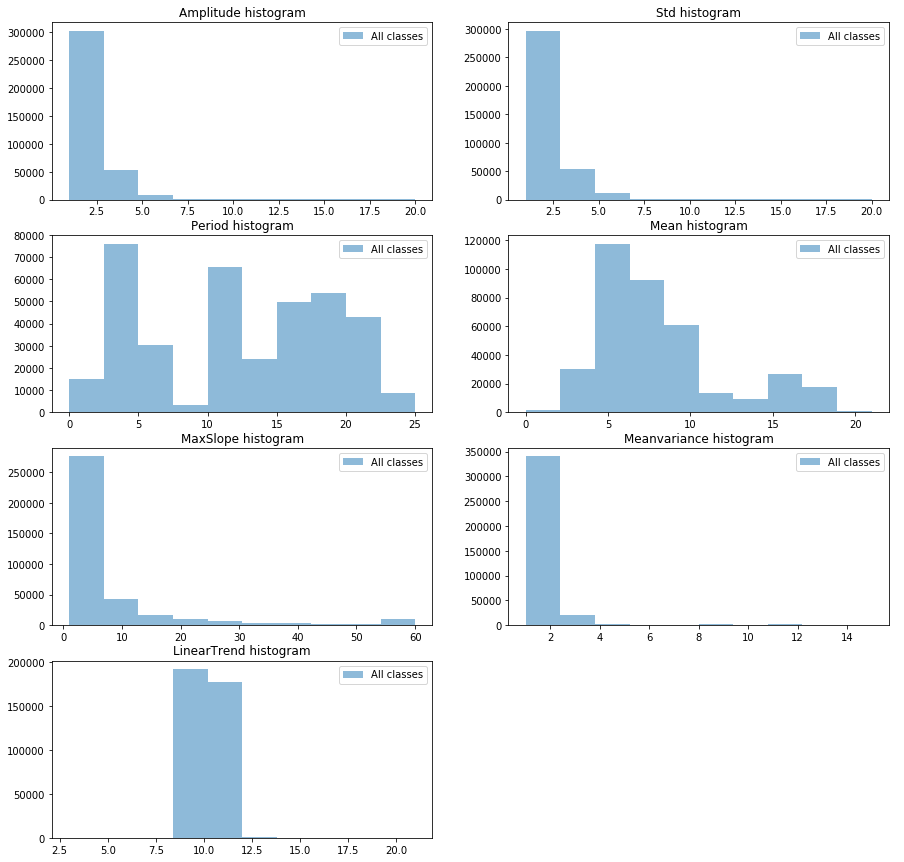

In [4]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
for i in range(7):
    ixs = i // 2, i % 2
    axes[ixs].set_title(f'{features[i]} histogram')
    axes[ixs].hist(X_train[:, i], alpha=0.5)
    axes[ixs].legend(['All classes'])
axes[3, 1].axis('off')
plt.show()

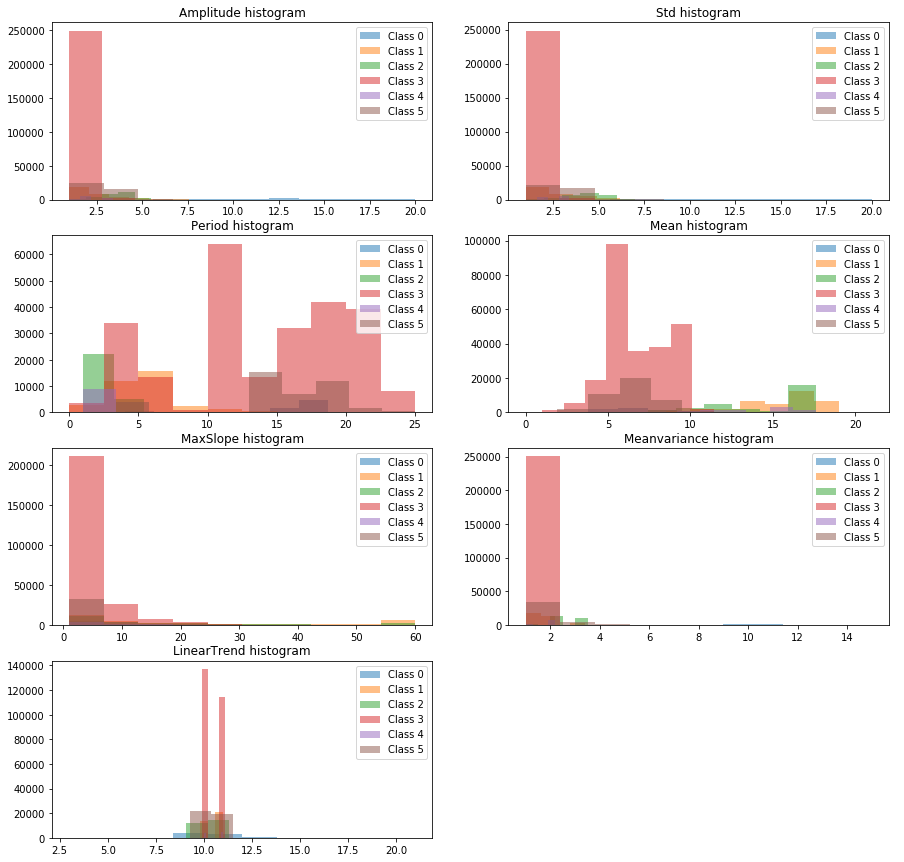

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,15))
for i in range(7):
    ixs = i // 2, i % 2
    axes[ixs].set_title(f'{features[i]} histogram')
    for cls in range(6):
        axes[ixs].hist(X_train[y_train == cls][:, i], alpha=0.5)
    axes[ixs].legend([f'Class {i}' for i in range(6)])
axes[3, 1].axis('off')
plt.show()

Como se puede observar, el segundo tipo de gráficos otorga un poco más de información en cuanto a las diferencias entre clases. Es posible tener la hipótesis de que aquellos histogramas donde más diferencias hay entre clases, como el de _Period_, son los que más información entregan a la hora de clasificar, mientras que los que se ven muy similares en todas las clases, como el de _MaxSlope_, son los que menos.

Si bien se afirmó en el enunciado que los valores están discretizados, no afecta el rendimiento asumir valores continuos para cada característica, y para así poder utilizar distribuciones de valores continuos, y hacer el análisis en ese dominio.

También es posible apreciar que no es del todo ridículo asumir distribuciones normales para cada característica en cada clase. Lo anterior por la cantidad de datos, y porque para cada clase se observa un parecido, quizás lejano, pero suficientemente plausible, a una normal de ciertos parámetros. Se discutirá más sobre esto en posteriores secciones.

## Naive Bayes

Un clasificador Naive Bayes es aquel que se basa en ciertas propiedades de las probabilidades, pero fundamentalmente apoyado en el teorema de Bayes. El objetivo es obtener la distribución de probabilidades de las clases o etiquetas de una instancia a clasificar dado un conjunto de datos de entrenamiento.

Para lo anterior, se basa en un supuesto muy importante que hace que se le llame _Naive_. El supuesto es que cada una de las características es independiente de las otras, por lo tanto no hay correlación entre ellas. Matemáticamente ese supuesto hace que los cálculos se simplifiquen mucho y se pueda llegar a una expresión simple para clasificar un elemento nuevo dado los datos anteriores.

En primer lugar el teorema de Bayes dice lo siguiente:

$$P(A\mid B) = \frac{P(A)P(B\mid A)}{P(B)}$$

Dicha fórmula como vimos en clases se puede entender como el producto del _prior_ o conocimiento a priori sobre la probabilidad de la clase $A$ con el _likelihood_ o probabilidad de los datos dada la clase, y el producto anterior con un termino de normalización dado por lo que se conoce como _evidence_.

El supuesto de independencia es importante para poder utilizar lo anterior de manera de simplificar una expresión que puede ser muy compleja si la cantidad de componentes o características de la instancia a predecir es muy grande.

Sabemos también que la probabilidad conjunta de dos variables se puede expresar así:

$$P(A, B) = P(A \mid B) P(B) = P(B \mid A) P(A)$$

En el mundo de los vectores de características la notación a utilizar es la siguiente: $y_k$ representa la clase de índice $k$ y $x_i$ son los componentes del vector a predecir $[x_i, \dots, x_F]$, considerando $F$ como la cantidad total de características. Así, el _likelihood_ se puede escribir de esta manera

$$P([x_1, \dots, x_F] \mid y_k)$$

, y la probabilidad buscada para clasificar es

$$P(y_k \mid [x_1, \dots, x_F]).$$

Ahora, como la probabilidad condicional se puede expresar en términos de la probabilidad conjunta, y aplicando sucesivamente la igualdad de la probabilidad conjunta para cada $i$, se puede obtener lo siguiente:

$$P(y_k, x_1, \dots, x_F) = P(x_1 \mid x_2, \dots, y_k) P(x_2 \mid x_3, \dots, y_k) \dots P(x_F \mid y_k)P(y_k)$$

Ahora entra en juego el supuesto de independencia de características, porque todas aquellas probabilidades que son de la forma $P(x_i \mid x_{i+1}, \dots, x_{F}, y_k)$ se pueden expresar como $P(x_i \mid y_k)$

Con lo anterior, se llega finalmente a que
$$P(y_k, x_1, \dots, x_F) = P(y_k) \prod_{i=1}^{F}P(x_i \mid y_k)$$

Una observación importante es que la probabilidad buscada por el clasificador es en realidad $P(y_k \mid [x_1, \dots, x_F])$, de modo que pasar de esa probabilidad a una en términos de probabilidades conjuntas es posible:

\begin{align*}
    P(y_k \mid [x_1, \dots, x_F]) &= \frac{P(y_k, x_1, \dots, x_F)}{P([x_1, \dots, x_F])}\\
    &= \frac{P(y_k) \prod_{i=1}^{F}P(x_i \mid y_k)}{P([x_1, \dots, x_F])}
\end{align*}

Como el denominador no depende de la clase en cuestión, y como se discutió en clases, se puede obviar ese elemento, porque lo que interesa es clasificar con esta información, y lo que se hará es seleccionar la clase $k$ que maximice la probabilidad, de modo que no es relevante la escala.

Finalmente se tiene que 

$$ P(y_k \mid [x_1, \dots, x_F]) \propto P(y_k) \prod_{i=1}^{F}P(x_i \mid y_k)$$

Y considerando que al ser una maximización por el método MAP (maximum a posteriori), no es necesario incluir las constantes, con lo que para clasificar se puede llegar a la siguiente expresión:

$$\DeclareMathOperator*{\argmax}{argmax} \hat{y} = \argmax_{k \in \{0, \dots, K\}} \quad P(y_k) \prod_{i=1}^{F}P(x_i \mid y_k)$$

Sin embargo, computar $P([x_1, \dots, x_F])$ es sencillo, por probabilidades totales, podemos condicionar en $y_k$ y sumar sobre todos los valores posibles de $y_k$, y además, haciendo la misma construcción iterativa anterior:

$$P([x_1, \dots, x_F]) = \sum_{k=1}^{K}P(y_k) \prod_{i=1}^{F} P(x_i \mid y_k)$$

Con esto, la probabilidad exacta (y completa, `posterior predictiva`) para una clase $y_k$ dado el vector $x$ que representa al dato, es la siguiente:

$$ P(y_k \mid [x_1, \dots, x_F]) = \frac{P(y_k) \prod_{i=1}^{F}P(x_i \mid y_k)}{\sum_{k=1}^{K}P(y_k) \prod_{i=1}^{F} P(x_i \mid y_k)}$$

Cada $P(x_i \mid y_k)$ corresponde a la probabilidad del valor de la característica $i$ dada la clase $k$, lo que quiere decir que se necesita saber como distribuye la clase $k$ para esa característica. 

Como se comentó anteriormente, se podría usar una distribución por característica, no por clase y característica, pero es una sobresimplificación, y como se mostró en los gráficos, claramente hay diferencias entre las clases para una misma característica.

Asumiendo _normalidad_, lo que se hará es obtener los parámetros de la media y la desviación para cada conjunto de datos, y con eso se armarán las normales para cada distribución deseada, de manera de obtener las probabilidades.

Notar que son $K \cdot F$ normales, en el dataset completo serían 42. Notar también que es posible utilizar normales multivariadas con matriz de covarianza la identidad, ya que es equivalente, por el supuesto _naive_ de independencia.

Según si se quiere usar un _approach_ `MLE` o `MAP` o de `Posterior predictiva`, es que se optaría por incluir el término de los _priors_, y el término de la probabilidad del vector. El primero corresponde a $P(y_k)$, y el segundo al denominador. Así, lo que se tendría es:

- `MLE`: considerar solo el numerador sin los _priors_: $\prod_{i=1}^{F}P(x_i \mid y_k)$, maximizar para obtener la clase que hace máxima dicha expresión.
- `MAP`: considerar el numerador con los _priors_: $P(y_k)\prod_{i=1}^{F}P(x_i \mid y_k)$, maximizar para obtener la clase que hace máxima dicha expresión

El tercero, no tiene sentido considerarlo como diferente puesto que el denominador es una constante normalizadora independiente de $y_k$ por lo que el resultado es idéntico al de `MAP`. Sin embargo, es importante notar que la única expresión que realmente representa una probabilidad es la última, y sumada sobre $k$ es igual a 1. 

Como en el enunciado se pedía la probabilidad, se realizó todo el método con la expresión completa, sin desmedro de que se podría fácilmente sacar el denominador y los resultados de la clasificación no variarían. También se podrían sacar los _priors_, pero los resultados serían más sobreajustados a los datos de entrenamiento.

### Código

In [6]:
from scipy.stats import norm

In [7]:
class GenericNaiveBayes:
    def __init__(self, distribution=norm):
        self.distribution = distribution
        if distribution != norm:
            raise NotImplementedError('Only normal distribution supported.')
    
    def predict(self, X):
        label = X.pop('y')
        if label not in self.K:
            raise Exception('Unknown label')
        values = np.zeros(self.F.size)
        for key in X.keys():
            i, = np.where(self.feature_names == key)
            values[i] = X[key]
        probs = self._predict(values)
        return probs[:, label][0]
    
    def predict_label(self, X):
        return np.argmax(self._predict(X), axis=1)
        
    def score(self, X, labels):
        return np.array(np.where((labels == self.predict_label(X)) == True)).size / labels.size
    
    def confussion_matrix(self, X, labels):
        predictions = self.predict_label(X)
        return pd.crosstab(labels, predictions, rownames=['Real class'], colnames=['Predicted class'])
    
    def plot_confussion_matrix(self, X, labels):
        cfm = self.confussion_matrix(X, labels)
        cfm_density = np.array([row / row.sum() for row in np.array(cfm)])
        cfms = [cfm, cfm_density]
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
        for i in range(2):
            ax[i].matshow(cfms[i], cmap='binary')
            for (k, j), z in np.ndenumerate(cfm):
                ax[i].text(j, k, z, ha='center', va='center', color='green', fontsize='large', fontweight='750')
            ax[i].set_title('Confussion Matrix' + (' (as density)' if i else ''))
            ax[i].set_ylabel('Real class')
            ax[i].set_xlabel('Predited class')
        plt.show()

In [8]:
class NaiveBayes(GenericNaiveBayes):
    def _prepare(self, data_frame):
        column_names = list(data_frame)
        self.feature_names = np.array([i for i in column_names if i != 'Class'])
        self.y = np.array(data_frame['Class'])
        self.X = np.array(data_frame[self.feature_names])
        self.F = np.arange(self.X.shape[1])
        self.K = np.unique(self.y)
        self.means = np.zeros((self.K.size, self.F.size))
        self.stds = np.zeros((self.K.size, self.F.size))
        self.normals = np.array([[None for f in self.F] for k in self.K])
        self.priors = np.array([self.y[self.y == k].size / self.y.size for k in self.K])
        
    def fit(self, data_frame):
        self._prepare(data_frame)
        for k in self.K:
            for i in self.F:
                subject = self.X[self.y == k][:, i]
                self.means[k, i] = mean = subject.mean()
                self.stds[k, i] = std = subject.std()
                self.normals[k, i] = self.distribution(mean, std)
    
    def _predict(self, X):
        if not hasattr(self, 'X') or not hasattr(self, 'y'):
            raise Exception(f'model.fit(df) must be called before model.predict(sample).')
        if len(X.shape) == 1:
            X = np.array([X])
        if self.F.size != X.shape[1]:
            raise Exception('You should train the model with the same number of features as the prediction')
        
        probs = np.zeros((X.shape[0], self.K.size))
        for k in self.K:
            probs[:, k] = np.prod(np.array([self.normals[k, i].pdf(X[:, i]) for i in self.F]), axis=0)
        return probs * self.priors / probs.sum(axis = 0)

En resumidas cuentas, lo que se hace es en entrenamiento obtener los parámetros $\mu_{k, i}$ y $\sigma_{k, i}$ para así poder definir cada normal $\mathcal{N}_{k, i}(\mu_{k, i}, \sigma_{k, i})$

Con eso, se procede a computar las probabilidades pedidas, para cada clase y para cada característica se computa con la función de densidad la probabilidad de que el $x_i$ dado corresponda a esa clase $k$, con la normal correspondiente. Luego se multiplican los valores para todos los $i$, se multiplica por un _prior_ que en este caso se estableció como la proporción de cada clase $k$ sobre la cantidad total, esto es $\frac{\#y_k}{\#y}$, y se divide por la _evidence_ que es la constante normalizadora.

In [9]:
df_train, df_test, _, _ = train_test_split(features=df, labels=df, proportion=0.95)

X_testing = np.array(df_test[[i for i in list(df_test) if i != 'Class']])
y_testing = np.array(df_test['Class'])

In [10]:
classifier = NaiveBayes()
classifier.fit(df_train)

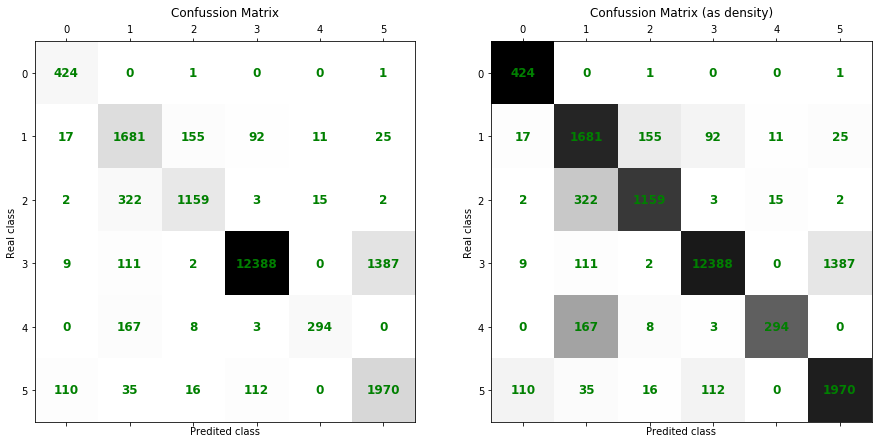

In [11]:
classifier.confussion_matrix(X_testing, y_testing)
classifier.plot_confussion_matrix(X_testing, y_testing)

Para ilustrar las matrices de confusión se muestran de dos maneras, una que simplemente muestra la frecuencia contrastada entre la clase real y la clase de la predicción, y otra que muestra lo mismo pero como densidad. Se realiza de esta segunda manera porque es más ilustrativa en cuanto no tiene el sesgo de que ciertas clases, como la 3 tienen más muestras que otras.

In [12]:
classifier.score(X_testing, y_testing)

0.8730143260890751

Como se aprecia el rendimiento es alto para lo sencillo del método sobre un _set_ que no se había observado en entrenamiento, lo que da luces de que los supuestos no eran malos y que con ellos se puede obtener predicciones decentes.

Según lo pedido en el enunciado se deja un ejemplo de como ejecutar la probabilidad dada una muestra en el formato especial que se pedía:

In [13]:
# usage example with X_testing[0]
label = 5
example = {[i for i in list(df_test) if i != 'Class'][i]: X_testing[0][i] for i in range(len(X_testing[0]))}
example['y'] = label # class to get prob of
print(example)
p = classifier.predict(example)
print(f'P(y = {label} | x) = {p}')

{'Amplitude': 3, 'Std': 3, 'Period': 5, 'Mean': 17, 'MaxSlope': 60, 'Meanvariance': 2, 'LinearTrend': 10, 'y': 5}
P(y = 5 | x) = 0.11012654991691169


## Bayesian Naive Bayes

Para este caso, es necesario introducir lo _bayesiano_ al método anterior. Hay varias formas de ver esto de manera formal, haciendo una derivación de las expresiones a utilizar desde un principio, pero en adelante se mostrará una explicación enfocada en las diferencias con el método anterior, y en la intuición.

En primer lugar el análisis de las probabilidades es análogo al anterior, sin embargo, no siguiendo la filosofía _bayesiana_, en el metodo `Naive Bayes` se fijaban distribuciones para la probabilidad de una instancia dada la clase, esto es $\prod_{i=1}^{F}P(x_i \mid y_k)$, que en este caso se asumieron normales.

Una consecuencia de lo anterior, por como se procedió, es que para esas distribuciones fijas los parámetros se obtenían de la muestra, esto es, media muestral y desviación muestral, con lo que quedaba finalmente una normal $\mathcal{N}(\mu, \sigma)$ que se interpretaba como "la probabilidad del vector dada la clase distribuye normal de dichos parametros".

El punto es que en el análisis anterior, se fijan los parámetros, sin considerar que estos pueden seguir una distribución. Por eso, en este método con el prefijo _bayesiano_ lo que se procede a hacer es sustituir dichas distribuciones fijas, por distribuciones basadas en muestreos de los parámetros.

Para eso, lo que se realizó fue obtener para cada clase y característica, en vez de una normal con media y desviación muestral, distribuciones para la media y para la desviación. Nuevamente se asumió normalidad pero ahora para los parámetros, muchas veces agrupados en la notación $\theta$ en la literatura. Ahora en vez de fijar directamente los parámetros según los que distribuyen los datos, se fijan los parámetros por los cuales distribuyen los parámetros de los datos. Con la poco legible frase anterior, lo que se desea expresar es que si bien se es _bayesiano_ para esos parámetros, siempre se termina fijando algún parámetro finalmente.

Las normales según las que se asume distribuyen las medias y desviaciones son las siguientes:
$$\mathcal{N}_{\mu}\left(\mu, \frac{\sigma}{\sqrt{n}}\right)$$
$$\mathcal{N}_{\sigma}\left(\sigma, \frac{\sigma}{\sqrt{2(n - 1)}}\right)$$

La decisión anterior basada en que esas son las medias que se utilizan para describir la media y desviación muestral. Para lo anterior me basé en [este](https://web.eecs.umich.edu/~fessler/papers/files/tr/stderr.pdf) y [este](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4452664/pdf/kjae-68-220.pdf) documento.

Con lo anterior, a la hora de calcular la probabilidad final, se itera una cantidad fija de veces, $I$, donde en cada iteración, para cada clase y para cada característica, en vez de usar la normal fija, se muestrea una media y una desviación, y con esas se arma la normal para calcular la probabilidad.

Luego de lo anterior, se cuida en dividir la suma de dichas probabilidades por la cantidad de iteraciones $I$, de modo de utilizar el promedio de las probabilidades dadas las muestras para obtener las probabilidades finales.

### Código

In [14]:
%reset -f array

In [15]:
class BayesianNaiveBayes(GenericNaiveBayes):
    def _prepare(self, data_frame):
        column_names = list(data_frame)
        self.feature_names = np.array([i for i in column_names if i != 'Class'])
        self.y = np.array(data_frame['Class'])
        self.X = np.array(data_frame[self.feature_names])
        self.F = np.arange(self.X.shape[1])
        self.K = np.unique(self.y)
        self.means = np.zeros((self.K.size, self.F.size))
        self.stds = np.zeros((self.K.size, self.F.size))
        self.parameter_normals = np.array([[[None, None] for f in self.F] for k in self.K])
        self.y_priors = np.array([self.y[self.y == k].size / self.y.size for k in self.K])
        
    def fit(self, data_frame):
        self._prepare(data_frame)
        for k in self.K:
            for i in self.F:
                subject = self.X[self.y == k][:, i]
                self.means[k, i] = mean = subject.mean()
                self.stds[k, i] = std = subject.std()
                n = len(subject)
                self.parameter_normals[k, i, 0] = self.distribution(mean, std / np.sqrt(n))
                self.parameter_normals[k, i, 1] = self.distribution(std, std / np.sqrt(2*(n - 1)))
                
    
    def _predict(self, X):
        if not hasattr(self, 'X') or not hasattr(self, 'y'):
            raise Exception(f'model.fit(df) must be called before model.predict(sample).')
        if len(X.shape) == 1:
            X = np.array([X])
        if self.F.size != X.shape[1]:
            raise Exception('You should train the model with the same number of features as the prediction')
        
        probs = np.zeros((X.shape[0], self.K.size))
        I = 25
        for j in range(I):
            for k in self.K:
                probs[:, k] += np.prod(np.array([self.distribution(self.parameter_normals[k, i, 0].rvs(),
                     self.parameter_normals[k, i, 1].rvs()).pdf(X[:, i]) for i in self.F]), axis=0) / I
        return probs * self.y_priors / probs.sum(axis = 0)

In [16]:
df_train, df_test, _, _ = train_test_split(features=df, labels=df, proportion=0.95)

X_testing = np.array(df_test[[i for i in list(df_test) if i != 'Class']])
y_testing = np.array(df_test['Class'])

In [17]:
classifier = BayesianNaiveBayes()
classifier.fit(df_train)

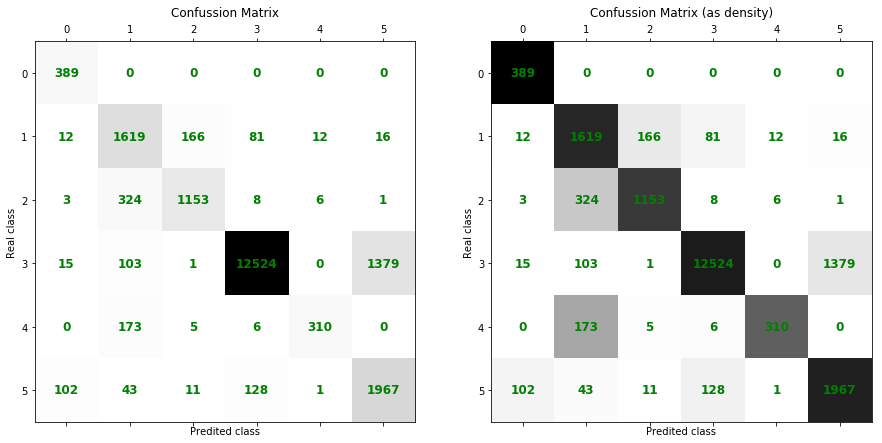

In [18]:
classifier.confussion_matrix(X_testing, y_testing)
classifier.plot_confussion_matrix(X_testing, y_testing)

In [19]:
classifier.score(X_testing, y_testing)

0.873820410545773

De modo similar se obtiene un resultado bastante alto para esta sección, sin embargo el valor comparativo no es del todo valioso porque el set de testing es distinto, ya que el procedimiento `train_test_split` se realizó nuevamente.

Dado lo anterior, se procede a realizar la estimación del score con el clasificador no _bayesiano_, pero con este mismo set, para ver la comparación:

In [20]:
clnb = NaiveBayes()
clnb.fit(df_train)
clnb.score(X_testing, y_testing)

0.873820410545773

El rendimiento sin utilizar el método _bayesiano_ es levemente diferente. Lo anterior puede deberse ciertamente a que las desviaciones de las distribuciones utilizadas para estimar los parámetros de las normales, fueron muy conservadores. Si se mueven dichos valores, o se cambian los centros de dichas normales para que no sean necesariamente la media o la desviación, los resultados efectivamente difieren.

Nuevamente se incluye un ejemplo con el formato especial pedido:

In [21]:
# usage example with X_testing[0]
label = 3
example = {[i for i in list(df_test) if i != 'Class'][i]: X_testing[0][i] for i in range(len(X_testing[0]))}
example['y'] = label # class to get prob of
p = classifier.predict(example)
print(f'P(y = {label} | x) = {p}')

P(y = 3 | x) = 0.6775262455447773


## Comentarios

### Normalidad

Como se ha comentado varias veces, se asumió la distribución normal para varias de las partes de ambos procedimientos, primero para como distribuyen las características en cada clase, y segundo para como distribuyen las medias y desviaciones de dichas normales que rigen a las características.

Este supuesto se puede probar y resulta ser bastante alejado de la realidad. Utilizando una de las herramientas de `scipy.stats`, la prueba `normaltest`, se ve que la probabilidad de que la distribución sea normal dado los datos para cada clase y característica es sumamente baja.

In [22]:
from scipy.stats import normaltest

In [23]:
X_all = np.array(df[[i for i in list(df) if i != 'Class']])
y_all = np.array(df['Class'])
pvalues = np.array([[normaltest(X_all[y_all == k][:, i])[1] for i in range(7)] for k in range(6)])

In [24]:
pvalues.mean()

8.531481923579615e-24

Como media el valor es muy cercano a cero, por lo que el caso no es optimista. Sin embargo se realizaron experimentos con diversos métodos de semejanza a distribuciones y diversas distribuciones y ninguna de las clásicas obtenía resultados satisfactorios, por lo que con lo bueno de los resultados, aún cuando los datos no distribuyan de esa forma estadísticamente, empíricamente se aprecia que es un supuesto razonable

Por otro lado, un supuesto dado por el modelo es el de la independencia, y se ha mostrado en diversos artículos que el apodo `Naive` no le hace justicia al método porque los rendimientos que obtiene son bastante buenos.

### Resultados

Se ejecutaron alrededor de 100 experimentos por cada clasificador con porciones aleatorias del set de datos para entrenamiento y testing (utilizando la misma división para ambos clasificadores), y se apreció que si bien la diferencia en rendimiento es marginal, la mayoría de las veces el rendimiento era superior para el método bayesiano.

Se probó modificando la cantidad de iteraciones del modelo bayesiano, y es posible notar que cuando las iteraciones son muchas, el rendimiento tiende a igualarse. Se había comentado anteriormente que lo bajas de las desviaciones tenían un efecto en que no cambiara mucho el rendimiento, pero también si las muestras son muchas, se tiende a las medias de las normales escogidas, que justamente son la media muestral y la desviación estándar muestral, lo que implica que a un número muy alto de iteraciones, el método bayesiano estaría, en esta implementación, convergiendo al no _bayesiano_. Lo anterior dado los supuestos de normalidad y la elección de parámetros.

Visto del lado contrario, si se aumentan las desviaciones para los parámetros, y se hacen pocas iteraciones, la variabilidad aumenta significativamente.

Por otro lado, se puede argumentar que dado los resultados obtenidos no vale la pena el costo que implica la versión bayesiana si el rendimiento aumenta tan poco (y hasta a veces disminuye). Lo anterior en base a que si bien las fases de entrenamiento de ambos algoritmos toman muy poco tiempo, la fase de testing puede crecer en tiempo muy aceleradamente si se aplican muchas iteraciones, ya que se hacen cálculos sobre todos los datos.

### Nota sobre las distribuciones para las medias y desviaciones

Como se comentó, en el método _bayesiano_, se utilizaron las normales explicadas para los parámetros, y se muestra una a modo de ejemplo para mostrar lo que se comentó, normales con poca desviación por lo tanto muy tendientes a la media.

In [25]:
ex_mean = classifier.means[0][0]
ex_std = classifier.stds[0][0]
a, b = classifier.parameter_normals[0, 0]

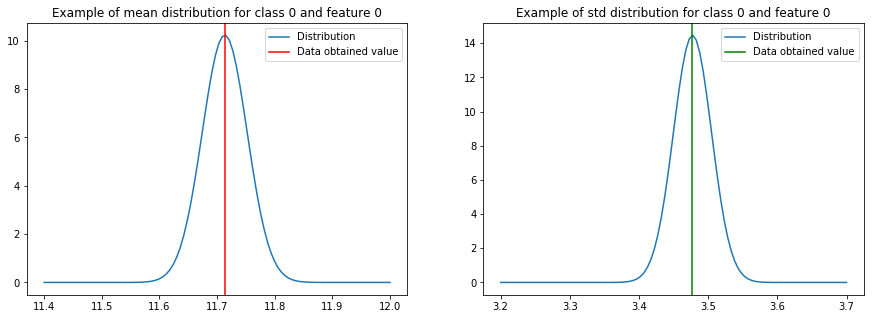

In [26]:
points = np.linspace(11.4, 12, num=100)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title('Example of mean distribution for class 0 and feature 0')
axes[0].plot(points, a.pdf(points))
axes[0].axvline(x=ex_mean, color='red')
axes[0].legend(['Distribution', 'Data obtained value'])

points = np.linspace(3.2, 3.7, num=100)
axes[1].set_title('Example of std distribution for class 0 and feature 0')
axes[1].plot(points, b.pdf(points))
axes[1].axvline(x=ex_std, color='green')
axes[1].legend(['Distribution', 'Data obtained value'])

plt.show()